## Setup

In [30]:
# Import dependencies.
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [31]:
engine = create_engine("sqlite:///../Resources/dow.sqlite", echo=False)

In [32]:
engine.execute(text('SELECT * FROM dow LIMIT 5')).fetchall()

[(1, 1, 'AA', '2011-01-07', 15.82, 16.72, 15.78, 16.42, 239655616, None),
 (2, 1, 'AA', '2011-01-14', 16.71, 16.71, 15.64, 15.97, 242963398, None),
 (3, 1, 'AA', '2011-01-21', 16.19, 16.38, 15.6, 15.79, 138428495, None),
 (4, 1, 'AA', '2011-01-28', 15.87, 16.63, 15.82, 16.13, 151379173, None),
 (5, 1, 'AA', '2011-02-04', 16.18, 17.39, 16.18, 17.14, 154387761, None)]

In [33]:
inspector = inspect(engine)
columns = inspector.get_columns('dow')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
quarter INTEGER
stock TEXT
date TEXT
open_price FLOAT
high_price FLOAT
low_price FLOAT
close_price FLOAT
volume INTEGER
percent_change FLOAT


## Reflect and query dates

In [34]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(autoload_with=engine)
Dow = Base.classes.dow

In [35]:
session = Session(engine)

## Analysis

Analyze the Average prices (open, high, low, close) for all stocks in the Month of May

In [36]:
# Query for the stock and average prices (open, high, low, close) 
# for all stock in the month of May
# Sort the result by stock name
sel = [Dow.stock, 
       func.avg(Dow.open_price), 
       func.avg(Dow.high_price), 
       func.avg(Dow.low_price), 
       func.avg(Dow.close_price)]
may_averages = session.query(*sel).\
    filter(func.strftime("%m", Dow.date) == "05").\
    group_by(Dow.stock).\
    order_by(Dow.stock).all()
may_averages

[('AA', 16.8475, 17.3375, 16.4175, 16.747500000000002),
 ('AXP', 49.89750000000001, 51.07, 49.315, 50.5025),
 ('BA', 78.7175, 79.2175, 76.8825, 78.2125),
 ('BAC', 12.0, 12.235, 11.7325, 11.8775),
 ('CAT', 108.5525, 110.5975, 104.045, 106.4),
 ('CSCO', 17.067500000000003, 17.255000000000003, 16.5925, 16.8575),
 ('CVX', 103.9725, 105.72749999999999, 100.4575, 102.76249999999999),
 ('DD', 53.9625, 54.9225, 52.14, 53.21),
 ('DIS', 42.3, 42.8175, 41.11749999999999, 41.900000000000006),
 ('GE', 19.96, 20.175, 19.4875, 19.740000000000002),
 ('HD', 36.765, 37.51, 36.504999999999995, 36.7625),
 ('HPQ', 39.315, 40.14, 37.8425, 38.54),
 ('IBM', 169.7025, 171.58, 166.9375, 169.11749999999998),
 ('INTC', 23.0975, 23.67, 22.652500000000003, 23.0225),
 ('JNJ', 65.6575, 66.8475, 65.0575, 66.08749999999999),
 ('JPM', 44.015, 44.709999999999994, 43.019999999999996, 43.527499999999996),
 ('KO', 67.5775, 68.32499999999999, 66.75750000000001, 67.4725),
 ('KRFT', 34.305, 35.0225, 33.945, 34.7375),
 ('MCD', 

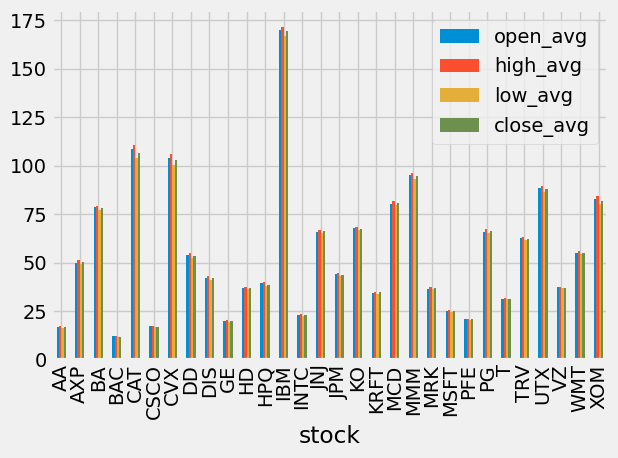

In [37]:
# Plot the Results in a Matplotlib bar chart
df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
df.set_index('stock', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()

### Bonus
Calculate the high-low peak-to-peak (PTP) values for `IBM` stock after `2011-05-31`. 
* Note: high-low PTP is calculated using `high_price` - `low_price`
* Use a DateTime.date object in the query filter
* Use list comprehension to create a list of dictionaries from the query results
* Create a dataframe from the list of dictionaries
* Use the `boxplot()` method on the dataframe to plot PTP distribution statistics

In [38]:
# Design a query to calculate the PTP for stock `IBM` after May, 2011
import datetime as dt

date = dt.datetime(2011, 5, 31)

results = session.query(Dow.high_price - Dow.low_price, 
                        Dow.date).\
                  filter(Dow.date > date).filter(Dow.stock == 'IBM').all()

# List comprehension solution
ptp_rows = [{"Date": result[1], "PTP": result[0]} for result in results]
ptp_rows

[{'Date': '2011-06-03', 'PTP': 5.759999999999991},
 {'Date': '2011-06-10', 'PTP': 3.0900000000000034},
 {'Date': '2011-06-17', 'PTP': 3.579999999999984},
 {'Date': '2011-06-24', 'PTP': 3.219999999999999}]

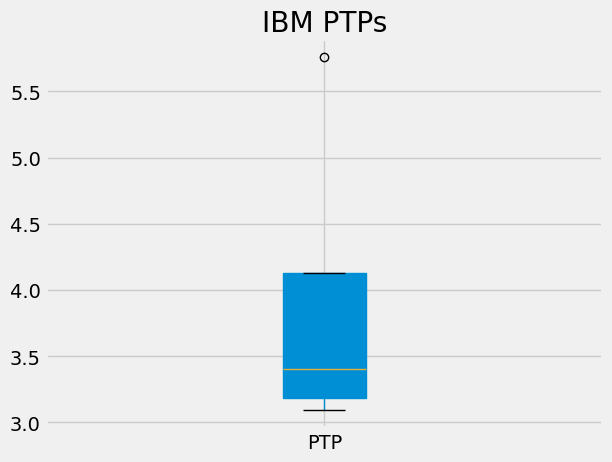

In [39]:
# Load the list comprehension rows into a dataframe, set the index to the date, and plot the PTPs
pd.DataFrame(ptp_rows).set_index("Date").boxplot(patch_artist=True)
plt.title("IBM PTPs")
plt.show()

In [50]:
# Query the opening prices for all stocks and store them in a DataFrame
sel_opening = [Dow.date, Dow.stock, Dow.open_price]
opening_prices = session.query(*sel_opening).all()
opening_df = pd.DataFrame(opening_prices, columns=['date', 'stock', 'open_price'])

# Pivot the DataFrame to have dates as index and stocks as columns
opening_pivot = opening_df.pivot(index='date', columns='stock', values='open_price')

# Print the first few rows of the DataFrame
print(opening_pivot.head())



stock          AA    AXP     BA    BAC    CAT   CSCO    CVX     DD    DIS  \
date                                                                        
2011-01-07  15.82  43.30  66.15  13.85  94.38  20.45  91.66  50.05  37.74   
2011-01-14  16.71  44.20  69.42  14.17  93.21  20.94  90.95  48.30  39.01   
2011-01-21  16.19  46.03  70.86  15.08  94.16  21.22  92.94  49.53  39.07   
2011-01-28  15.87  46.05  71.52  14.25  92.71  20.84  93.89  48.44  39.64   
2011-02-04  16.18  44.13  69.26  13.71  96.13  20.93  93.85  50.15  39.04   

stock          GE  ...    MRK   MSFT    PFE     PG      T    TRV    UTX  \
date               ...                                                    
2011-01-07  18.49  ...  36.29  28.05  17.70  64.39  29.68  56.09  79.19   
2011-01-14  18.61  ...  37.26  28.20  18.22  64.40  28.54  53.12  78.27   
2011-01-21  18.98  ...  34.07  28.16  18.35  65.65  28.55  54.62  79.28   
2011-01-28  19.93  ...  33.99  28.02  18.33  65.90  28.46  55.14  80.26   
2011-02-04

In [43]:
# Query the closing prices for all stocks and store them in a DataFrame
sel_closing = [Dow.date, Dow.stock, Dow.close_price]
closing_prices = session.query(*sel_closing).all()
closing_df = pd.DataFrame(closing_prices, columns=['date', 'stock', 'close_price'])

# Pivot the DataFrame to have dates as index and stocks as columns
closing_pivot = closing_df.pivot(index='date', columns='stock', values='close_price')

# Print the first few rows of the DataFrame
print(closing_pivot.head())

stock          AA    AXP     BA    BAC    CAT   CSCO    CVX     DD    DIS  \
date                                                                        
2011-01-07  16.42  44.36  69.38  14.25  93.73  20.97  91.19  49.76  39.45   
2011-01-14  15.97  46.25  70.07  15.25  94.01  21.21  92.83  49.80  39.29   
2011-01-21  15.79  46.00  71.68  14.25  92.75  20.72  93.78  48.35  39.74   
2011-01-28  16.13  43.86  69.23  13.60  95.68  20.93  93.37  50.29  38.85   
2011-02-04  17.14  43.82  71.38  14.29  99.59  22.05  97.11  52.53  40.71   

stock          GE  ...    MRK   MSFT    PFE     PG      T    TRV    UTX  \
date               ...                                                    
2011-01-07  18.43  ...  37.35  28.60  18.34  64.50  28.85  53.33  79.08   
2011-01-14  18.82  ...  34.23  28.30  18.34  65.53  28.43  54.63  79.08   
2011-01-21  19.74  ...  33.90  28.02  18.36  65.91  28.33  55.00  80.20   
2011-01-28  20.20  ...  33.07  27.75  18.15  64.20  27.49  55.81  81.43   
2011-02-04

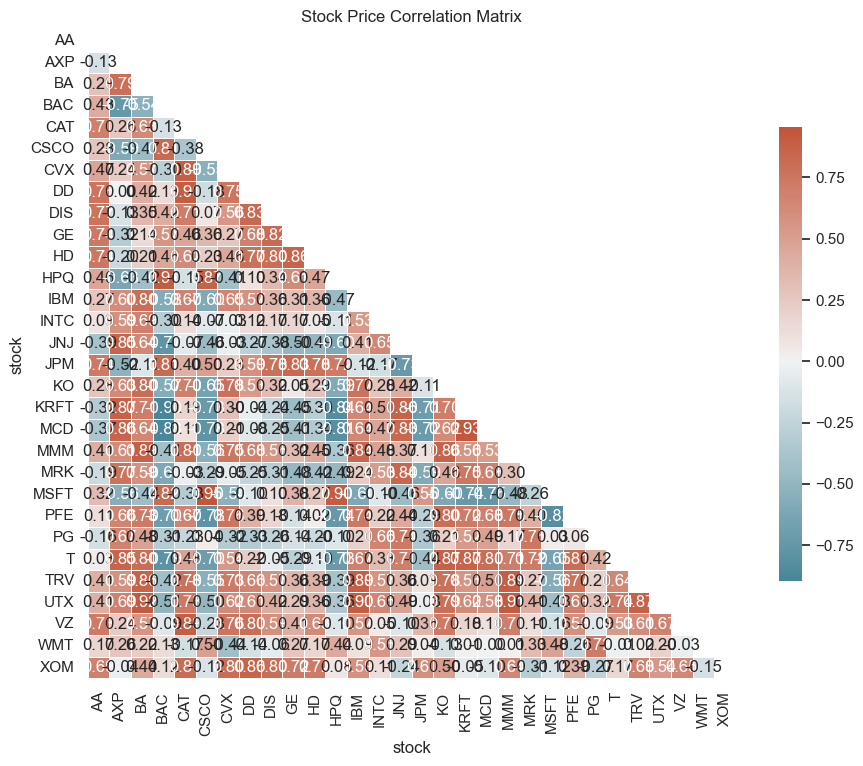

In [53]:
import seaborn as sns
import numpy as np
# Calculate correlation matrix
correlation_matrix = closing_pivot.corr()

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(style='white')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Create a mask for the upper triangle

# Create a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0, annot=True,
            fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": 0.7})
            
plt.title('Stock Price Correlation Matrix')
plt.show()


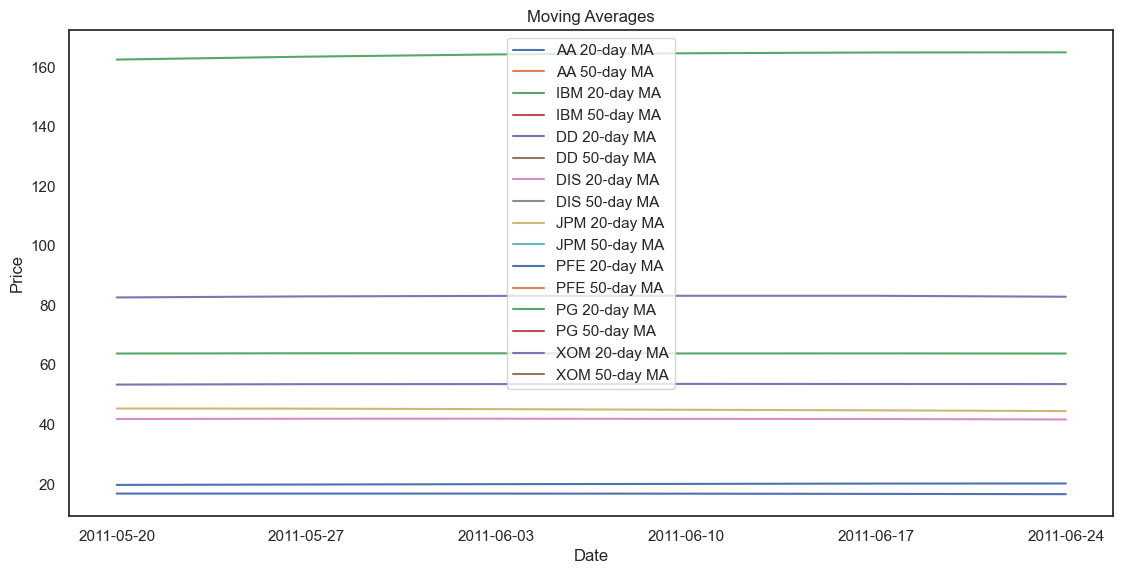

In [59]:
#keep track of the moving averages of each stock
plt.figure(figsize=(12, 6))
for stock in ['AA', 'IBM', 'DD', 'DIS', 'JPM', 'PFE', 'PG', 'XOM']:  # Choose stocks for comparison
    plt.plot(closing_pivot.index, closing_pivot[stock].rolling(window=20).mean(), label=f'{stock} 20-day MA')
    plt.plot(closing_pivot.index, closing_pivot[stock].rolling(window=50).mean(), label=f'{stock} 50-day MA')
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
